Total samples: 100
Training samples: 80
Testing samples: 20

--- Starting Grid Search Hyperparameter Tuning ---
Fitting 5 folds for each of 36 candidates, totalling 180 fits

             OPTIMIZATION RESULTS
Best Cross-Validation Accuracy: 0.8250
Best Parameters Found:
  logreg__C: 10.0
  logreg__penalty: l2
  tfidf__max_features: 3000
  tfidf__ngram_range: (1, 2)

Final Test Set Accuracy: 0.8500

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         9
           1       0.79      1.00      0.88        11

    accuracy                           0.85        20
   macro avg       0.89      0.83      0.84        20
weighted avg       0.88      0.85      0.84        20


--- Generating Visualizations ---


/tmp/ipython-input-3687603496.py:109: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='viridis')


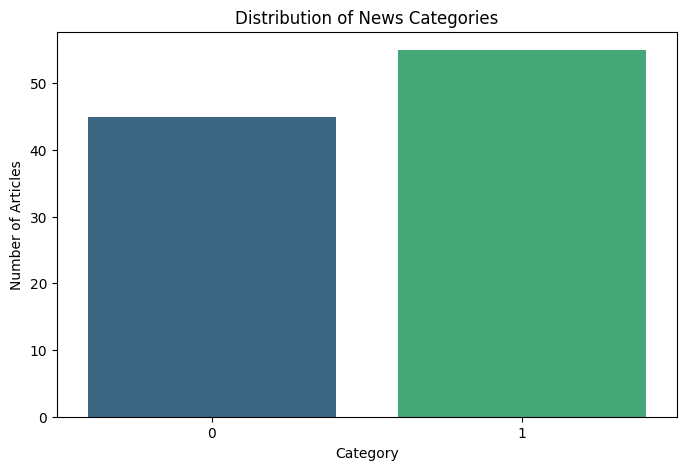

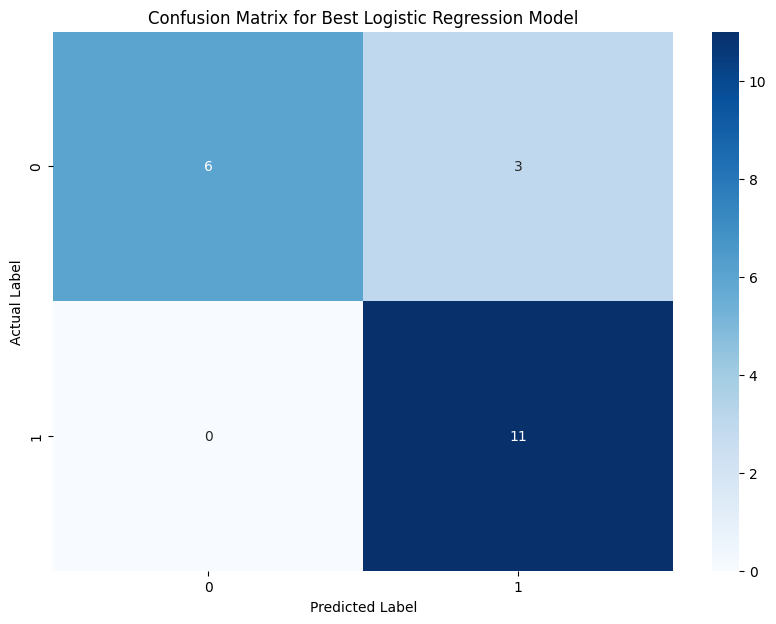

/tmp/ipython-input-3687603496.py:162: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10.values, y=top_10.index, ax=ax, palette='viridis')
/tmp/ipython-input-3687603496.py:162: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10.values, y=top_10.index, ax=ax, palette='viridis')


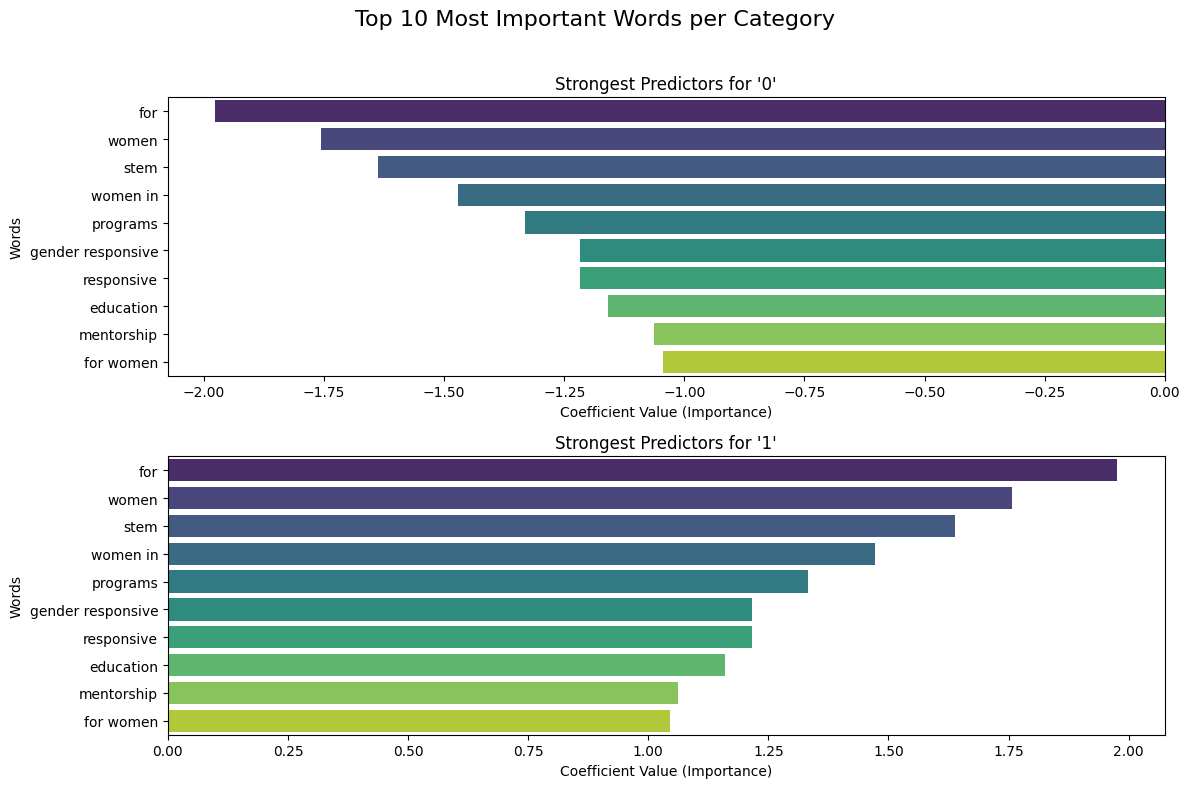

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score

# --- 1. Data Loading and Preparation ---

# Load the dataset (ensure 'Dataset100.csv' is uploaded to your Colab environment)
df = pd.read_csv("Dataset100.csv")

# Combine 'title' and 'summary' into a single, rich text feature
df['full_text'] = df['title'] + " " + df['summary']

# Define features (X) and labels (y)
X = df['full_text']
y = df['label']

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Total samples: {len(X)}")
print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")
print("\n--- Starting Grid Search Hyperparameter Tuning ---")

# --- 2. Build the Pipeline and Parameter Grid ---

# Create a pipeline that first transforms the text (vectorizer) and then trains the model (classifier)
pipeline = Pipeline([
    # Step 1: Feature Extraction using TF-IDF Vectorizer
    ('tfidf', TfidfVectorizer()),
    # Step 2: Classification using Logistic Regression
    ('logreg', LogisticRegression(solver='liblinear', max_iter=1000, random_state=42))
])

# Define the parameter grid to search for the best combination:
param_grid = {
    # Feature Engineering (Vectorization) Optimization:
    'tfidf__ngram_range': [(1, 1), (1, 2)], # Test unigrams (1,1) and unigrams+bigrams (1,2)
    'tfidf__max_features': [3000, 5000, 8000], # Limit features to focus on most important ones

    # Logistic Regression Hyperparameter Tuning:
    'logreg__C': [0.1, 1.0, 10.0], # Inverse of regularization strength (C). Testing weak, moderate, strong regularization.
    'logreg__penalty': ['l1', 'l2'], # Testing L1 (feature selection) and L2 (default) regularization.
}

# --- 3. Execute Grid Search Cross-Validation ---

# GridSearchCV searches all combinations of parameters using 5-fold cross-validation
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,                 # Use 5-fold cross-validation
    scoring='accuracy',   # Optimize for accuracy
    verbose=1,
    n_jobs=-1             # Use all available cores for faster computation
)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# --- 4. Evaluation and Results ---

# Get the best model from the search
best_model = grid_search.best_estimator_

print("\n" + "="*50)
print("             OPTIMIZATION RESULTS")
print("="*50)
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")
print("Best Parameters Found:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")
print("="*50)

# Evaluate the best model on the unseen test set
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)

print(f"\nFinal Test Set Accuracy: {test_accuracy:.4f}")
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred))

# Optional: To inspect the feature importance (coefficients) of the best model:
# logreg_weights = best_model.named_steps['logreg'].coef_[0]
# feature_names = best_model.named_steps['tfidf'].get_feature_names_out()
# feature_weights = pd.Series(logreg_weights, index=feature_names).sort_values(ascending=False)
# print("\nTop 10 Most Positive (Label 1) Predictors:")
# print(feature_weights.head(10))
# print("\nTop 10 Most Negative (Label 0) Predictors:")
# print(feature_weights.tail(10))

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ==============================================================================
# 5. Visualize the Results
# ==============================================================================

# Graph 1: Show the distribution of the labels in the entire dataset
print("\n--- Generating Visualizations ---")
plt.figure(figsize=(8, 5))
sns.countplot(x='label', data=df, palette='viridis')
plt.title('Distribution of News Categories')
plt.xlabel('Category')
plt.ylabel('Number of Articles')
plt.show()

# Graph 2: Create a confusion matrix for the best model
cm = confusion_matrix(y_test, y_pred)
class_names = best_model.classes_

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix for Best Logistic Regression Model')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# ==============================================================================
# Graph 3: Top Feature Importance (Words per Category) - CORRECTED
# ==============================================================================

# Get the feature names from the TF-IDF vectorizer in the best pipeline
feature_names = best_model.named_steps['tfidf'].get_feature_names_out()

# Get the coefficients (weights) from the logistic regression model
coefficients = best_model.named_steps['logreg'].coef_
class_names = best_model.classes_

# --- NEW: Handle the binary classification case ---
# If there are only 2 classes, scikit-learn only returns one set of coefficients
if len(class_names) == 2:
    # We can manually create the coefficients for the other class, as they are just the negative
    # This reshapes the coefficients to the expected (2, num_features) shape
    coefficients = np.vstack([-coefficients[0], coefficients[0]])
# --------------------------------------------------

# Create a DataFrame to make it easy to view
coef_df = pd.DataFrame(coefficients, columns=feature_names, index=class_names).T

# Plot the top 10 features for each class
plt.figure(figsize=(12, len(class_names) * 4))
plt.suptitle('Top 10 Most Important Words per Category', fontsize=16)

for i, category in enumerate(class_names):
    ax = plt.subplot(len(class_names), 1, i + 1)
    # For binary classification, one class will have positive coefficients and the other negative.
    # We'll plot the 10 largest for one and 10 smallest (most negative) for the other.
    if len(class_names) == 2 and i == 0:
        top_10 = coef_df[category].nsmallest(10).sort_values() # Most negative predictors
    else:
        top_10 = coef_df[category].nlargest(10) # Most positive predictors

    sns.barplot(x=top_10.values, y=top_10.index, ax=ax, palette='viridis')
    ax.set_title(f"Strongest Predictors for '{category}'")
    ax.set_xlabel('Coefficient Value (Importance)')
    ax.set_ylabel('Words')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
